<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/July16_Speech_CompleteV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Initial Setup and Data Loading
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install -q librosa soundfile speechbrain whisper-jax transformers datasets torch torchaudio
!pip install -q scikit-learn networkx plotly umap-learn

# Memory optimization imports
import psutil
import torch
torch.cuda.empty_cache()
gc.collect()

def get_memory_usage():
    """Monitor memory usage"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # MB

print(f"Initial memory usage: {get_memory_usage():.2f} MB")

# Define paths
BASE_PATH = "/content/drive/MyDrive/Voice/extracted/ADReSSo21"
PATHS = {
    'diagnosis_train_audio_ad': f"{BASE_PATH}/diagnosis/train/audio/ad",
    'diagnosis_train_audio_cn': f"{BASE_PATH}/diagnosis/train/audio/cn",
    'diagnosis_train_seg_ad': f"{BASE_PATH}/diagnosis/train/segmentation/ad",
    'diagnosis_train_seg_cn': f"{BASE_PATH}/diagnosis/train/segmentation/cn",
    'progression_test_audio': f"{BASE_PATH}/progression/test-dist/audio",
    'progression_test_seg': f"{BASE_PATH}/progression/test-dist/segmentation",
    'features': f"{BASE_PATH}/features",
    'transcripts': f"{BASE_PATH}/transcripts",
    'models': f"{BASE_PATH}/models",
    'visualizations': f"{BASE_PATH}/visualizations"
}

# Create output directories
for path in PATHS.values():
    os.makedirs(path, exist_ok=True)

# Create subdirectories for transcripts
transcript_dirs = [
    f"{PATHS['transcripts']}/train/ad",
    f"{PATHS['transcripts']}/train/cn",
    f"{PATHS['transcripts']}/test-dist",
    f"{PATHS['features']}/audio",
    f"{PATHS['features']}/text",
    f"{PATHS['models']}/bert",
    f"{PATHS['models']}/vit",
    f"{PATHS['models']}/two_branch"
]

for dir_path in transcript_dirs:
    os.makedirs(dir_path, exist_ok=True)

def scan_dataset():
    """Scan and organize dataset files"""
    dataset_info = {
        'train_ad_audio': [],
        'train_cn_audio': [],
        'train_ad_seg': [],
        'train_cn_seg': [],
        'test_audio': [],
        'test_seg': []
    }

    # Scan training data
    if os.path.exists(PATHS['diagnosis_train_audio_ad']):
        dataset_info['train_ad_audio'] = [f for f in os.listdir(PATHS['diagnosis_train_audio_ad']) if f.endswith('.wav')]

    if os.path.exists(PATHS['diagnosis_train_audio_cn']):
        dataset_info['train_cn_audio'] = [f for f in os.listdir(PATHS['diagnosis_train_audio_cn']) if f.endswith('.wav')]

    if os.path.exists(PATHS['diagnosis_train_seg_ad']):
        dataset_info['train_ad_seg'] = [f for f in os.listdir(PATHS['diagnosis_train_seg_ad']) if f.endswith('.csv')]

    if os.path.exists(PATHS['diagnosis_train_seg_cn']):
        dataset_info['train_cn_seg'] = [f for f in os.listdir(PATHS['diagnosis_train_seg_cn']) if f.endswith('.csv')]

    # Scan test data
    if os.path.exists(PATHS['progression_test_audio']):
        dataset_info['test_audio'] = [f for f in os.listdir(PATHS['progression_test_audio']) if f.endswith('.wav')]

    if os.path.exists(PATHS['progression_test_seg']):
        dataset_info['test_seg'] = [f for f in os.listdir(PATHS['progression_test_seg']) if f.endswith('.csv')]

    return dataset_info

# Scan dataset
dataset_info = scan_dataset()

# Print dataset summary
print("Dataset Summary:")
print(f"Train AD audio files: {len(dataset_info['train_ad_audio'])}")
print(f"Train CN audio files: {len(dataset_info['train_cn_audio'])}")
print(f"Train AD segmentation files: {len(dataset_info['train_ad_seg'])}")
print(f"Train CN segmentation files: {len(dataset_info['train_cn_seg'])}")
print(f"Test audio files: {len(dataset_info['test_audio'])}")
print(f"Test segmentation files: {len(dataset_info['test_seg'])}")

# Create metadata DataFrame
def create_metadata_df():
    """Create metadata DataFrame for efficient data management"""
    metadata = []

    # Add training data
    for file in dataset_info['train_ad_audio']:
        metadata.append({
            'file_id': file.replace('.wav', ''),
            'audio_path': f"{PATHS['diagnosis_train_audio_ad']}/{file}",
            'seg_path': f"{PATHS['diagnosis_train_seg_ad']}/{file.replace('.wav', '.csv')}",
            'label': 'ad',
            'split': 'train'
        })

    for file in dataset_info['train_cn_audio']:
        metadata.append({
            'file_id': file.replace('.wav', ''),
            'audio_path': f"{PATHS['diagnosis_train_audio_cn']}/{file}",
            'seg_path': f"{PATHS['diagnosis_train_seg_cn']}/{file.replace('.wav', '.csv')}",
            'label': 'cn',
            'split': 'train'
        })

    # Add test data
    for file in dataset_info['test_audio']:
        metadata.append({
            'file_id': file.replace('.wav', ''),
            'audio_path': f"{PATHS['progression_test_audio']}/{file}",
            'seg_path': f"{PATHS['progression_test_seg']}/{file.replace('.wav', '.csv')}",
            'label': 'unknown',
            'split': 'test'
        })

    return pd.DataFrame(metadata)

metadata_df = create_metadata_df()
print(f"\nMetadata DataFrame created with {len(metadata_df)} entries")
print(f"Memory usage after setup: {get_memory_usage():.2f} MB")

# Save metadata
metadata_df.to_csv(f"{BASE_PATH}/metadata.csv", index=False)
print("Setup completed successfully!")

# Display first few rows
print("\nMetadata sample:")
print(metadata_df.head())

# Check class distribution
print(f"\nClass distribution in training set:")
print(metadata_df[metadata_df['split'] == 'train']['label'].value_counts())

Mounted at /content/drive
ERROR: Could not find a version that satisfies the requirement whisper-jax (from versions: none)
ERROR: No matching distribution found for whisper-jax
Initial memory usage: 578.61 MB
Dataset Summary:
Train AD audio files: 87
Train CN audio files: 79
Train AD segmentation files: 87
Train CN segmentation files: 79
Test audio files: 32
Test segmentation files: 15

Metadata DataFrame created with 198 entries
Memory usage after setup: 579.02 MB
Setup completed successfully!

Metadata sample:
    file_id                                         audio_path  \
0  adrso047  /content/drive/MyDrive/Voice/extracted/ADReSSo...   
1  adrso128  /content/drive/MyDrive/Voice/extracted/ADReSSo...   
2  adrso110  /content/drive/MyDrive/Voice/extracted/ADReSSo...   
3  adrso036  /content/drive/MyDrive/Voice/extracted/ADReSSo...   
4  adrso045  /content/drive/MyDrive/Voice/extracted/ADReSSo...   

                                            seg_path label  split  
0  /content/drive

Starting Initial EDA...
Processing 5 AD samples and 5 CN samples


Processing audio batches: 100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


Extracted features from 10 files
Memory usage: 753.90 MB


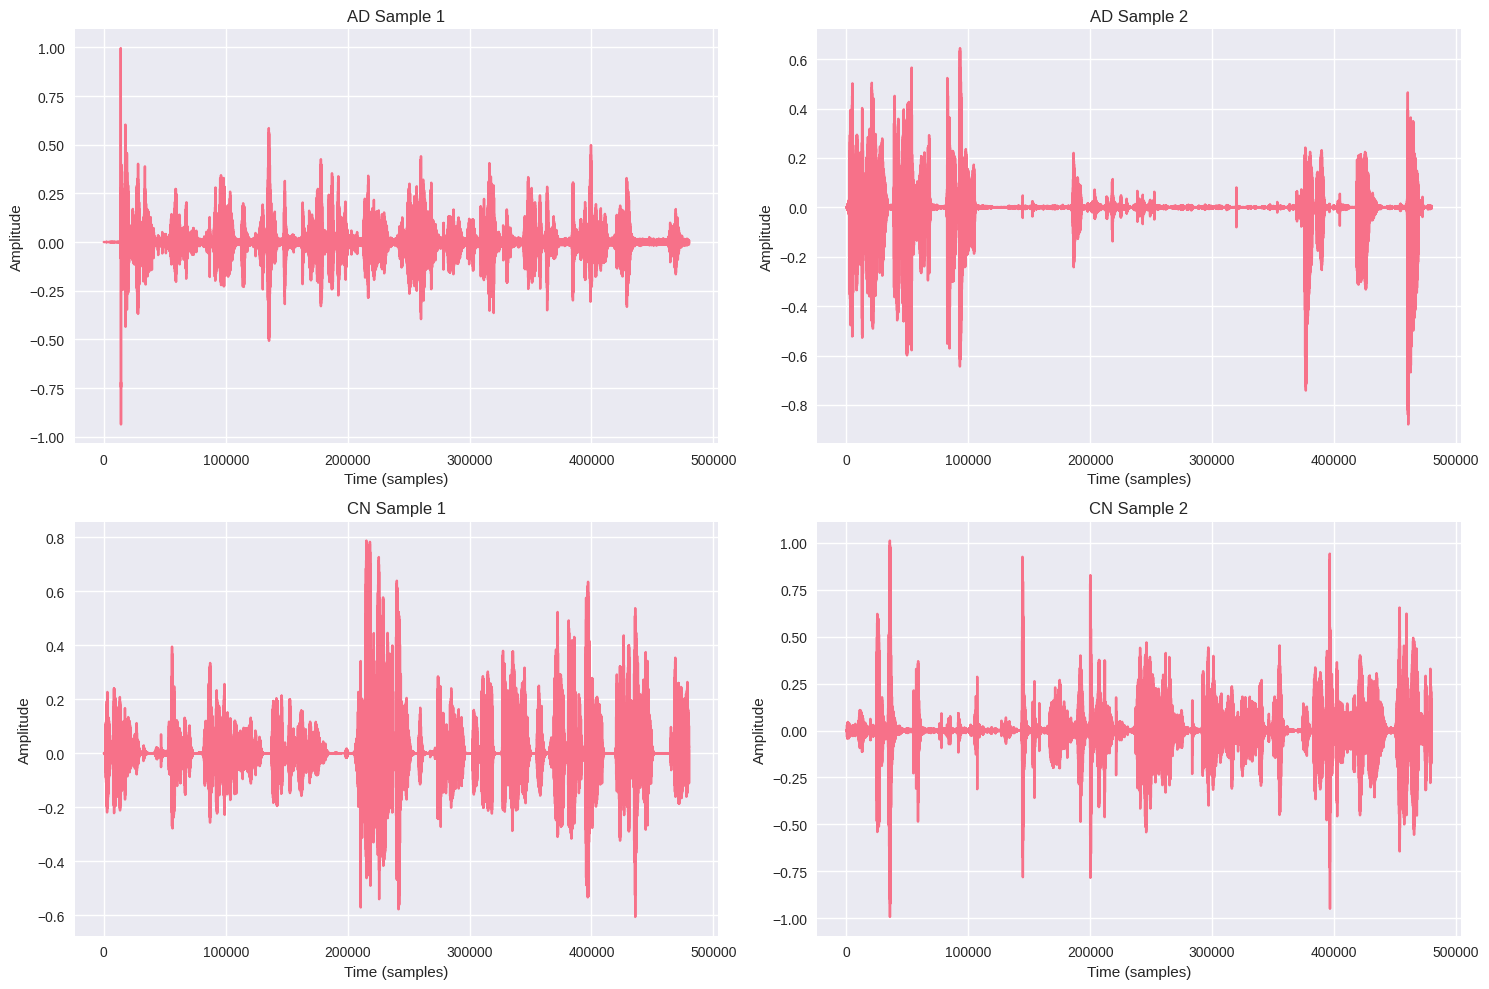

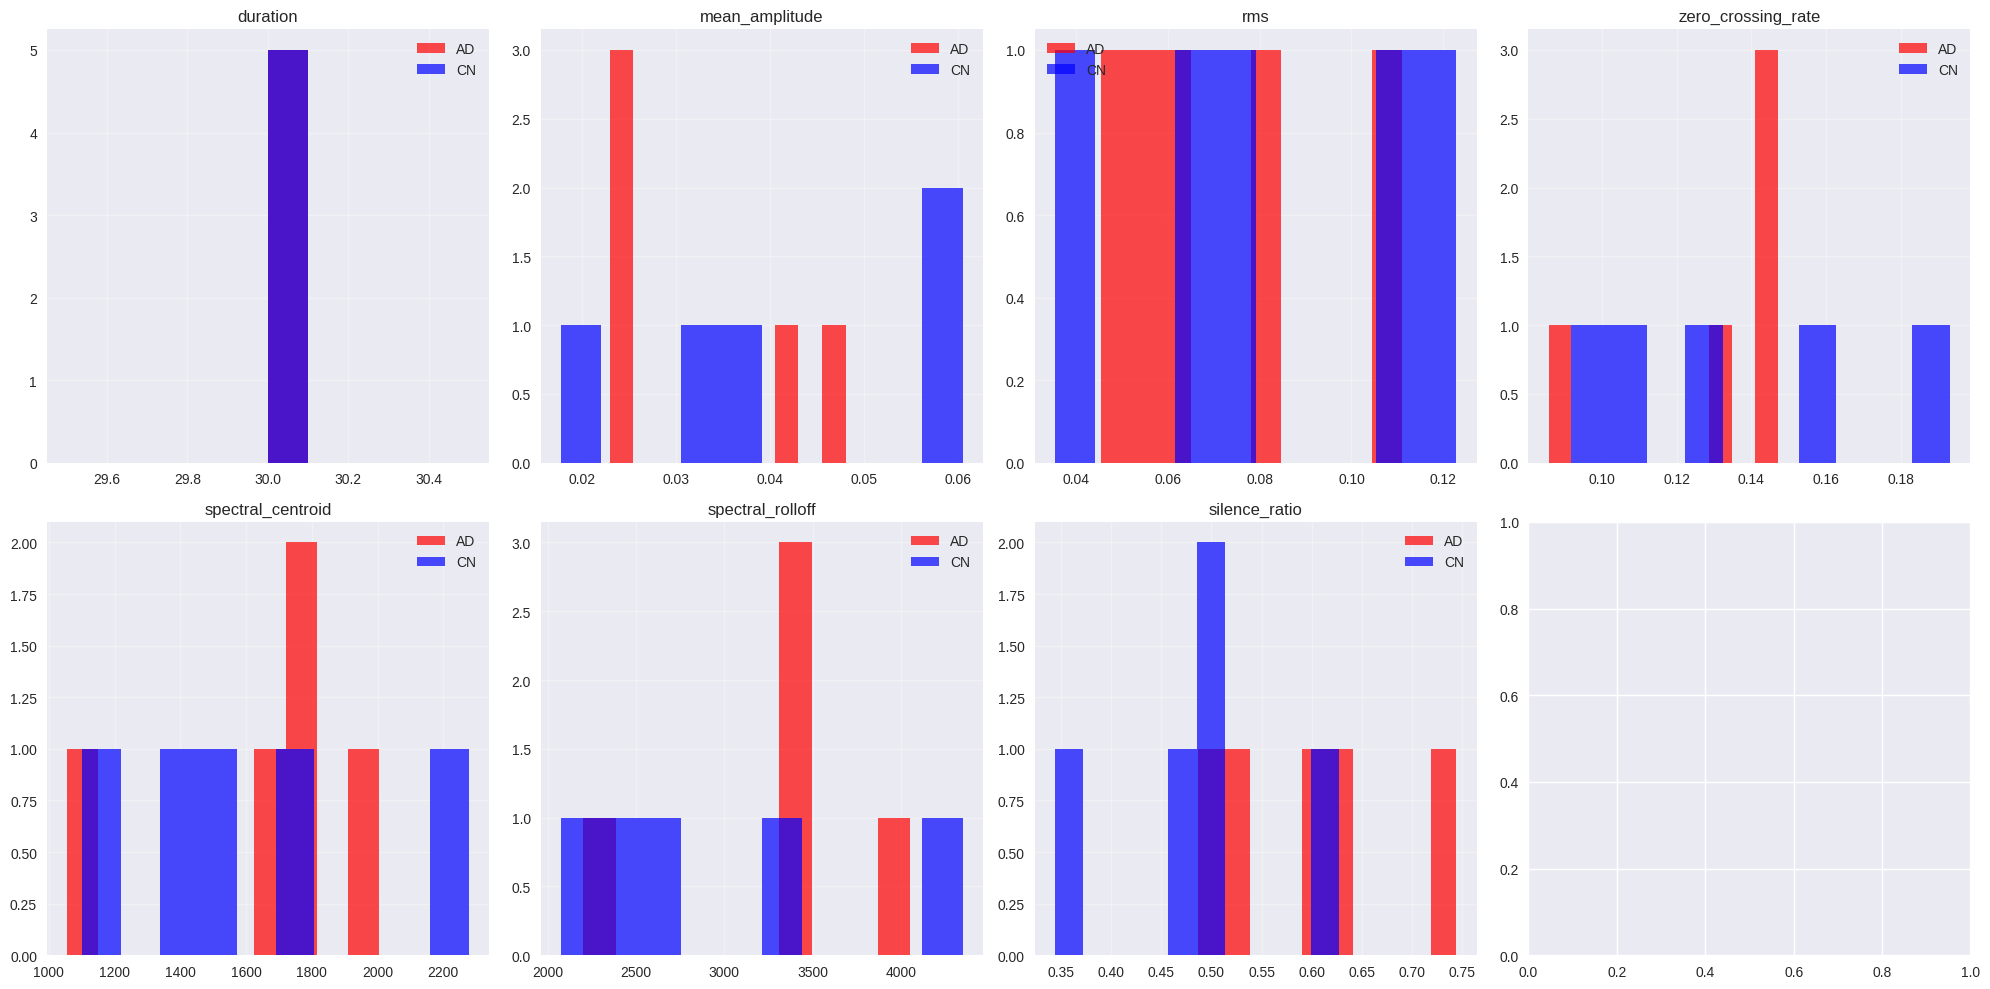

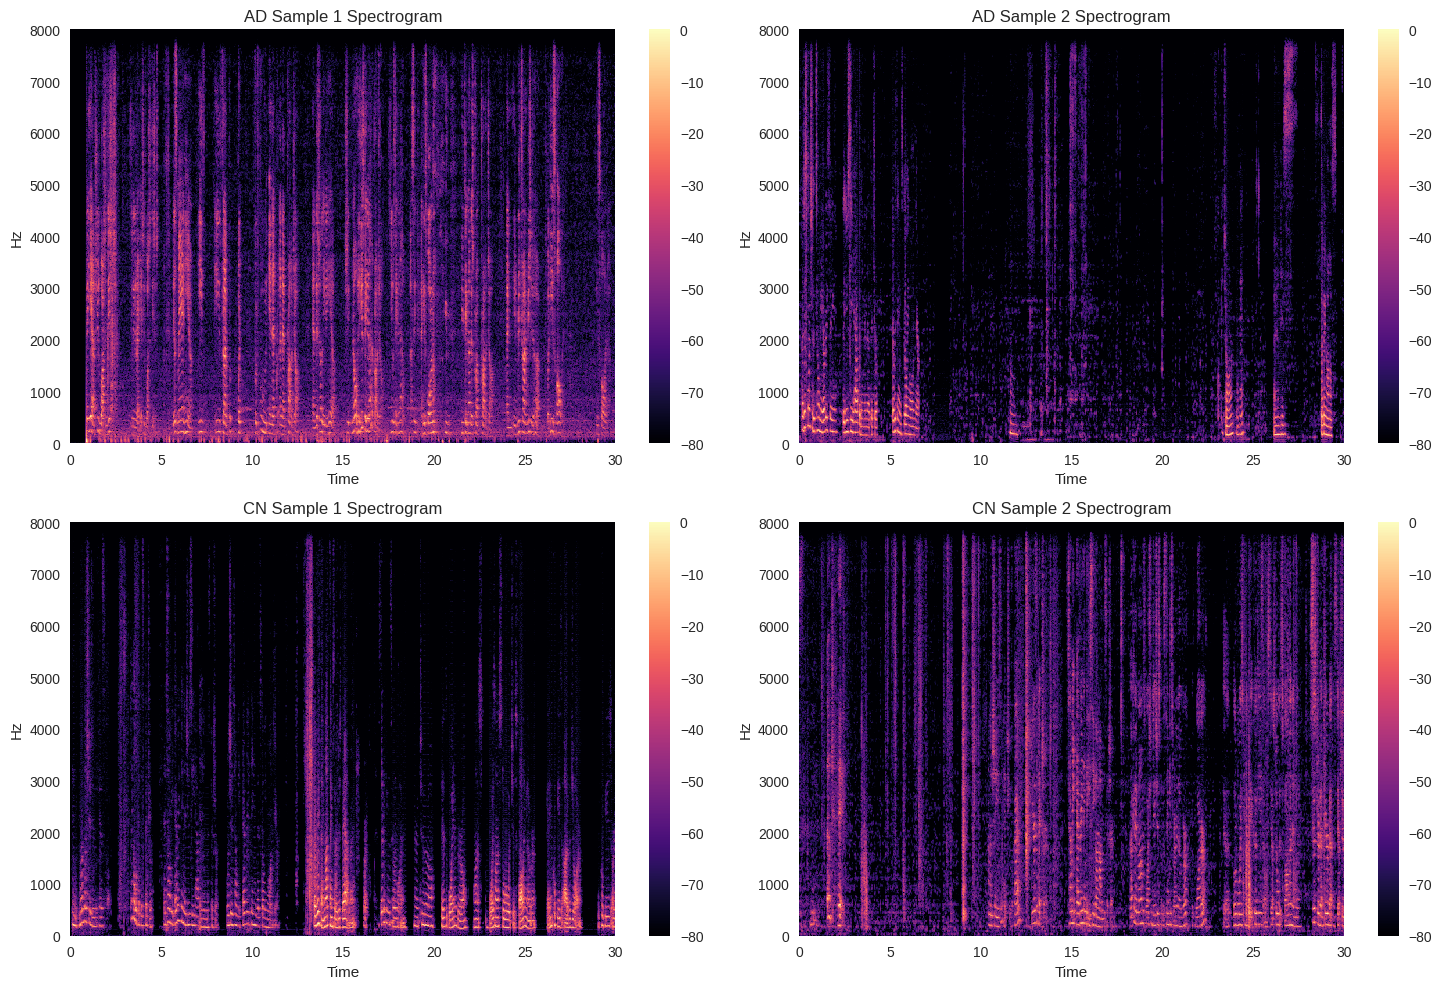

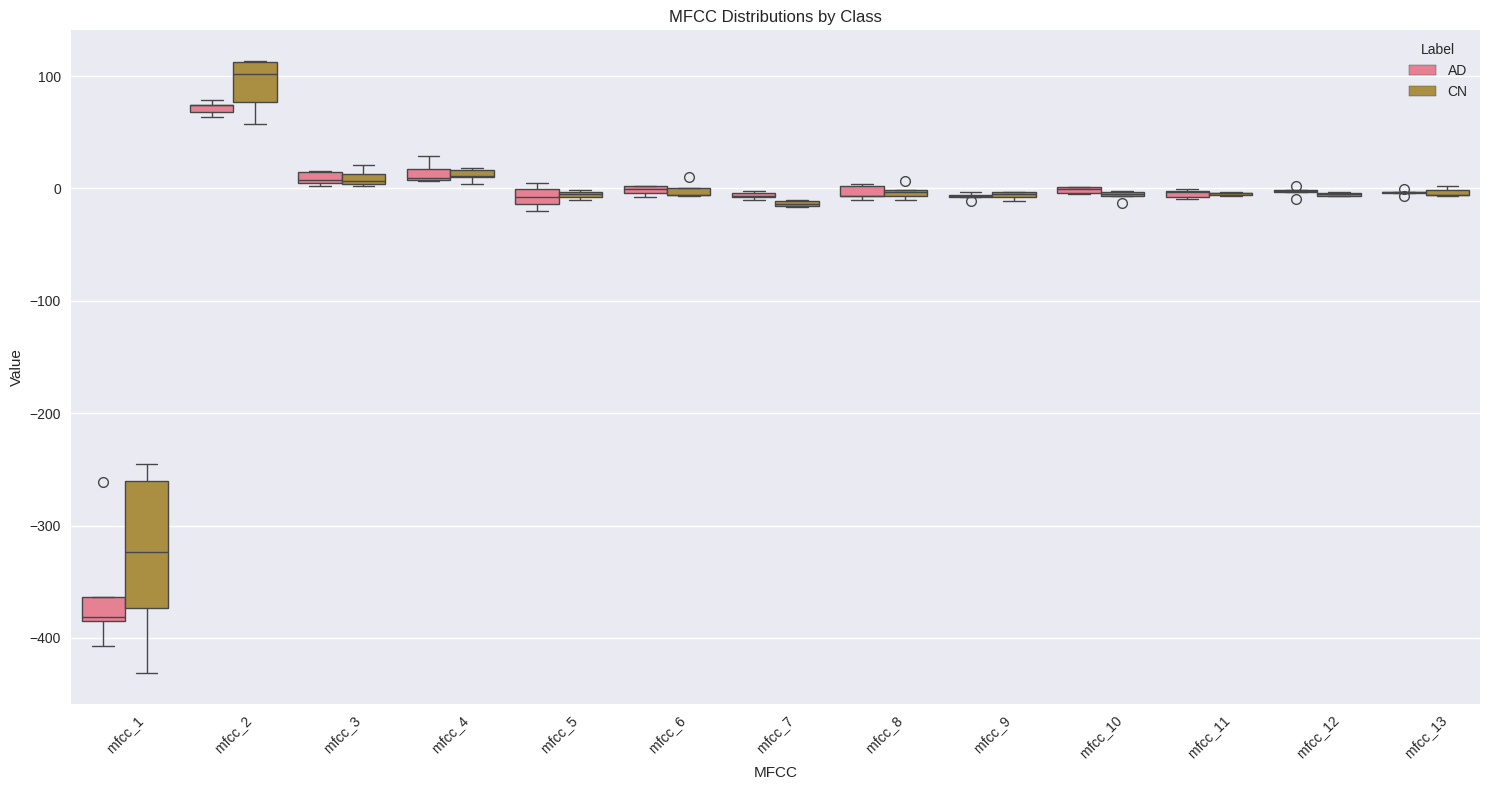

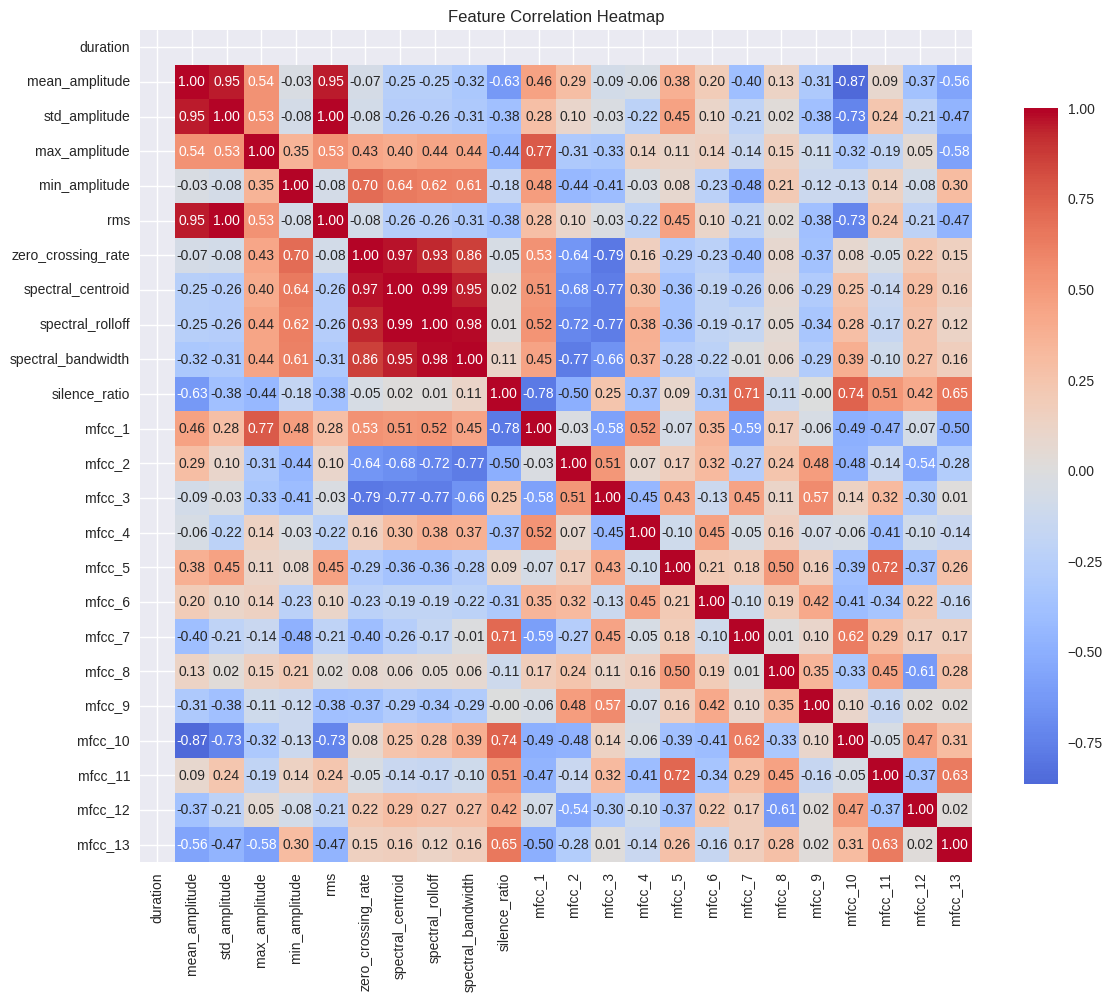

Summary Statistics by Class:
      duration                  mean_amplitude             rms          \
          mean  std   min   max           mean     std    mean     std   
label                                                                    
ad        30.0  0.0  30.0  30.0         0.0320  0.0117  0.0702  0.0261   
cn        30.0  0.0  30.0  30.0         0.0417  0.0177  0.0809  0.0344   

      zero_crossing_rate         spectral_centroid           silence_ratio  \
                    mean     std              mean       std          mean   
label                                                                        
ad                0.1307  0.0258         1650.6860  358.1299        0.5959   
cn                0.1350  0.0409         1586.4457  452.4380        0.4871   

               
          std  
label          
ad     0.0985  
cn     0.1017  

Outlier Detection (z-score > 3):
duration: 0 outliers
mean_amplitude: 0 outliers
rms: 0 outliers
spectral_centroid: 0 outliers



52851

In [2]:
# Step 2: Initial EDA - Memory Optimized for 12GB RAM
# Process files in batches to avoid memory issues

import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
import pandas as pd
import gc
import os
from tqdm import tqdm

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Memory-efficient audio loading function
def load_audio_safe(file_path, sr=16000, max_duration=30):
    """Load audio file with memory safety"""
    try:
        # Load only first 30 seconds to manage memory
        audio, _ = librosa.load(file_path, sr=sr, duration=max_duration)
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def extract_basic_features(audio, sr=16000):
    """Extract basic audio features efficiently"""
    if audio is None or len(audio) == 0:
        return None

    features = {
        'duration': len(audio) / sr,
        'mean_amplitude': np.mean(np.abs(audio)),
        'std_amplitude': np.std(audio),
        'max_amplitude': np.max(np.abs(audio)),
        'min_amplitude': np.min(np.abs(audio)),
        'rms': np.sqrt(np.mean(audio**2)),
        'zero_crossing_rate': librosa.feature.zero_crossing_rate(audio)[0].mean(),
        'spectral_centroid': librosa.feature.spectral_centroid(y=audio, sr=sr)[0].mean(),
        'spectral_rolloff': librosa.feature.spectral_rolloff(y=audio, sr=sr)[0].mean(),
        'spectral_bandwidth': librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0].mean(),
        'silence_ratio': np.sum(np.abs(audio) < 0.01) / len(audio)
    }

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}'] = mfccs[i].mean()

    return features

# Process files in batches
def process_audio_batch(file_paths, batch_size=10):
    """Process audio files in batches to manage memory"""
    features_list = []

    for i in tqdm(range(0, len(file_paths), batch_size), desc="Processing audio batches"):
        batch_files = file_paths[i:i+batch_size]
        batch_features = []

        for file_path in batch_files:
            audio = load_audio_safe(file_path)
            features = extract_basic_features(audio)

            if features:
                features['file_path'] = file_path
                features['file_id'] = os.path.basename(file_path).replace('.wav', '')
                batch_features.append(features)

            # Clear memory
            del audio
            gc.collect()

        features_list.extend(batch_features)

        # Clear batch memory
        del batch_features
        gc.collect()

    return features_list

# Load metadata
metadata_df = pd.read_csv(f"{BASE_PATH}/metadata.csv")

# Get sample files for detailed analysis
sample_ad_files = metadata_df[(metadata_df['label'] == 'ad') & (metadata_df['split'] == 'train')]['audio_path'].head(5).tolist()
sample_cn_files = metadata_df[(metadata_df['label'] == 'cn') & (metadata_df['split'] == 'train')]['audio_path'].head(5).tolist()

print("Starting Initial EDA...")
print(f"Processing {len(sample_ad_files)} AD samples and {len(sample_cn_files)} CN samples")

# Process samples
ad_features = process_audio_batch(sample_ad_files)
cn_features = process_audio_batch(sample_cn_files)

# Convert to DataFrames
ad_df = pd.DataFrame(ad_features)
cn_df = pd.DataFrame(cn_features)

# Add labels
ad_df['label'] = 'ad'
cn_df['label'] = 'cn'

# Combine
features_df = pd.concat([ad_df, cn_df], ignore_index=True)

print(f"Extracted features from {len(features_df)} files")
print(f"Memory usage: {get_memory_usage():.2f} MB")

# 1. Time-Domain Analysis
def plot_waveforms():
    """Plot sample waveforms"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot AD samples
    for i, file_path in enumerate(sample_ad_files[:2]):
        audio = load_audio_safe(file_path)
        if audio is not None:
            axes[0, i].plot(audio)
            axes[0, i].set_title(f'AD Sample {i+1}')
            axes[0, i].set_xlabel('Time (samples)')
            axes[0, i].set_ylabel('Amplitude')

    # Plot CN samples
    for i, file_path in enumerate(sample_cn_files[:2]):
        audio = load_audio_safe(file_path)
        if audio is not None:
            axes[1, i].plot(audio)
            axes[1, i].set_title(f'CN Sample {i+1}')
            axes[1, i].set_xlabel('Time (samples)')
            axes[1, i].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.savefig(f"{PATHS['visualizations']}/waveforms_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

plot_waveforms()

# 2. Feature Distribution Analysis
def plot_feature_distributions():
    """Plot feature distributions"""
    feature_cols = ['duration', 'mean_amplitude', 'rms', 'zero_crossing_rate',
                   'spectral_centroid', 'spectral_rolloff', 'silence_ratio']

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for i, feature in enumerate(feature_cols):
        if feature in features_df.columns:
            ad_data = features_df[features_df['label'] == 'ad'][feature]
            cn_data = features_df[features_df['label'] == 'cn'][feature]

            axes[i].hist(ad_data, alpha=0.7, label='AD', bins=10, color='red')
            axes[i].hist(cn_data, alpha=0.7, label='CN', bins=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{PATHS['visualizations']}/feature_distributions.png", dpi=150, bbox_inches='tight')
    plt.show()

plot_feature_distributions()

# 3. Spectrograms
def plot_spectrograms():
    """Plot spectrograms for sample files"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # AD spectrograms
    for i, file_path in enumerate(sample_ad_files[:2]):
        audio = load_audio_safe(file_path)
        if audio is not None:
            D = librosa.stft(audio)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            img = librosa.display.specshow(S_db, sr=16000, x_axis='time', y_axis='hz', ax=axes[0, i])
            axes[0, i].set_title(f'AD Sample {i+1} Spectrogram')
            plt.colorbar(img, ax=axes[0, i])

    # CN spectrograms
    for i, file_path in enumerate(sample_cn_files[:2]):
        audio = load_audio_safe(file_path)
        if audio is not None:
            D = librosa.stft(audio)
            S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
            img = librosa.display.specshow(S_db, sr=16000, x_axis='time', y_axis='hz', ax=axes[1, i])
            axes[1, i].set_title(f'CN Sample {i+1} Spectrogram')
            plt.colorbar(img, ax=axes[1, i])

    plt.tight_layout()
    plt.savefig(f"{PATHS['visualizations']}/spectrograms_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

plot_spectrograms()

# 4. MFCC Analysis
def plot_mfcc_analysis():
    """Plot MFCC feature analysis"""
    mfcc_cols = [col for col in features_df.columns if col.startswith('mfcc_')]

    if mfcc_cols:
        # Box plots for MFCCs
        fig, ax = plt.subplots(figsize=(15, 8))

        mfcc_data = []
        labels = []
        groups = []

        for mfcc_col in mfcc_cols:
            mfcc_data.extend(features_df[features_df['label'] == 'ad'][mfcc_col].tolist())
            labels.extend(['AD'] * len(features_df[features_df['label'] == 'ad']))
            groups.extend([mfcc_col] * len(features_df[features_df['label'] == 'ad']))

            mfcc_data.extend(features_df[features_df['label'] == 'cn'][mfcc_col].tolist())
            labels.extend(['CN'] * len(features_df[features_df['label'] == 'cn']))
            groups.extend([mfcc_col] * len(features_df[features_df['label'] == 'cn']))

        plot_df = pd.DataFrame({
            'MFCC': groups,
            'Value': mfcc_data,
            'Label': labels
        })

        sns.boxplot(data=plot_df, x='MFCC', y='Value', hue='Label', ax=ax)
        ax.set_title('MFCC Distributions by Class')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        plt.tight_layout()
        plt.savefig(f"{PATHS['visualizations']}/mfcc_analysis.png", dpi=150, bbox_inches='tight')
        plt.show()

plot_mfcc_analysis()

# 5. Correlation Analysis
def plot_correlation_heatmap():
    """Plot correlation heatmap of features"""
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['file_id']]

    if len(numeric_cols) > 1:
        corr_matrix = features_df[numeric_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, fmt='.2f', cbar_kws={"shrink": .8})
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.savefig(f"{PATHS['visualizations']}/correlation_heatmap.png", dpi=150, bbox_inches='tight')
        plt.show()

plot_correlation_heatmap()

# 6. Summary Statistics
def generate_summary_stats():
    """Generate and save summary statistics"""
    summary_stats = features_df.groupby('label').agg({
        'duration': ['mean', 'std', 'min', 'max'],
        'mean_amplitude': ['mean', 'std'],
        'rms': ['mean', 'std'],
        'zero_crossing_rate': ['mean', 'std'],
        'spectral_centroid': ['mean', 'std'],
        'silence_ratio': ['mean', 'std']
    }).round(4)

    print("Summary Statistics by Class:")
    print(summary_stats)

    # Save to CSV
    summary_stats.to_csv(f"{PATHS['visualizations']}/summary_statistics.csv")

    return summary_stats

summary_stats = generate_summary_stats()

# 7. Anomaly Detection
def detect_anomalies():
    """Detect outliers in the dataset"""
    outliers = {}

    for feature in ['duration', 'mean_amplitude', 'rms', 'spectral_centroid']:
        if feature in features_df.columns:
            z_scores = np.abs(zscore(features_df[feature]))
            outliers[feature] = np.sum(z_scores > 3)

    print("\nOutlier Detection (z-score > 3):")
    for feature, count in outliers.items():
        print(f"{feature}: {count} outliers")

    return outliers

outliers = detect_anomalies()

# Save features DataFrame
features_df.to_csv(f"{PATHS['features']}/initial_eda_features.csv", index=False)

print(f"\nInitial EDA completed!")
print(f"Features saved to: {PATHS['features']}/initial_eda_features.csv")
print(f"Visualizations saved to: {PATHS['visualizations']}/")
print(f"Final memory usage: {get_memory_usage():.2f} MB")

# Clear memory
del ad_features, cn_features, ad_df, cn_df
gc.collect()

In [4]:
# ============================================================================
# STEP 3: LIGHT PREPROCESSING
# ============================================================================

class AudioPreprocessor:
    def __init__(self, target_sr=16000, normalize=True):
        self.target_sr = target_sr
        self.normalize = normalize

    def load_and_preprocess(self, audio_path, max_duration=30):
        """Load and preprocess audio file"""
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=None)

            # Resample to target sample rate
            if sr != self.target_sr:
                audio = librosa.resample(audio, orig_sr=sr, target_sr=self.target_sr)

            # Convert to mono if stereo
            if audio.ndim > 1:
                audio = librosa.to_mono(audio)

            # Limit duration
            if len(audio) > max_duration * self.target_sr:
                audio = audio[:max_duration * self.target_sr]

            # Normalize amplitude
            if self.normalize:
                audio = librosa.util.normalize(audio)

            # Remove silence
            audio = self.remove_silence(audio)

            return audio, self.target_sr

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None, None

    def remove_silence(self, audio, threshold=0.01):
        """Remove silence from audio based on amplitude threshold"""
        # Find non-silent segments
        non_silent = np.abs(audio) > threshold

        if np.any(non_silent):
            # Find start and end of non-silent regions
            start = np.where(non_silent)[0][0]
            end = np.where(non_silent)[0][-1]
            return audio[start:end+1]
        else:
            return audio

    def check_audio_quality(self, audio, sr):
        """Check audio quality and return statistics"""
        if audio is None or len(audio) == 0:
            return None

        return {
            'duration': len(audio) / sr,
            'mean_amplitude': np.mean(np.abs(audio)),
            'max_amplitude': np.max(np.abs(audio)),
            'snr': self.calculate_snr(audio),
            'is_corrupted': len(audio) < 0.1 * sr  # Less than 0.1 seconds
        }

    def calculate_snr(self, audio):
        """Calculate Signal-to-Noise Ratio"""
        try:
            # Simple SNR calculation
            signal_power = np.mean(audio**2)
            noise_power = np.var(audio)
            snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
            return snr
        except:
            return 0.0

def align_with_segmentation(audio_path, seg_path, sr=16000):
    """Align audio with segmentation data from CSV"""
    try:
        # Load segmentation data
        seg_df = pd.read_csv(seg_path)

        # Load audio
        audio, _ = librosa.load(audio_path, sr=sr)

        # Extract segments based on CSV
        segments = []
        for _, row in seg_df.iterrows():
            start_time = row.get('start_time', 0)
            end_time = row.get('end_time', len(audio)/sr)

            start_sample = int(start_time * sr)
            end_sample = int(end_time * sr)

            if start_sample < len(audio) and end_sample <= len(audio):
                segment = audio[start_sample:end_sample]
                segments.append({
                    'audio': segment,
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': end_time - start_time
                })

        return segments

    except Exception as e:
        print(f"Error aligning {audio_path} with {seg_path}: {e}")
        return []

# Process all audio files
def preprocess_all_audio():
    """Preprocess all audio files in the dataset"""
    print("Starting audio preprocessing...")

    preprocessor = AudioPreprocessor()
    metadata_df = pd.read_csv(f"{BASE_PATH}/metadata.csv")

    processed_data = []
    corrupted_files = []

    for idx, row in metadata_df.iterrows():
        audio_path = row['audio_path']
        seg_path = row['seg_path']

        # Preprocess audio
        audio, sr = preprocessor.load_and_preprocess(audio_path)

        if audio is not None:
            # Check quality
            quality = preprocessor.check_audio_quality(audio, sr)

            if not quality['is_corrupted']:
                # Align with segmentation
                segments = align_with_segmentation(audio_path, seg_path, sr)

                processed_data.append({
                    'file_id': row['file_id'],
                    'audio': audio,
                    'sr': sr,
                    'segments': segments,
                    'quality': quality,
                    'label': row['label'],
                    'split': row['split']
                })
            else:
                corrupted_files.append(row['file_id'])
        else:
            corrupted_files.append(row['file_id'])

    print(f"Processed {len(processed_data)} files successfully")
    print(f"Found {len(corrupted_files)} corrupted files")

    return processed_data, corrupted_files

In [5]:
# ============================================================================
# STEP 4: TRANSCRIPT GENERATION
# ============================================================================

class TranscriptGenerator:
    def __init__(self, model_name="base"):
        self.model = whisper.load_model(model_name)

    def transcribe_audio(self, audio_path):
        """Transcribe audio to text using Whisper"""
        try:
            result = self.model.transcribe(audio_path)
            return {
                'text': result['text'],
                'segments': result['segments'],
                'language': result['language']
            }
        except Exception as e:
            print(f"Error transcribing {audio_path}: {e}")
            return None

    def clean_transcript(self, text):
        """Clean transcript text"""
        # Remove filler words
        fillers = ['um', 'uh', 'ah', 'er', 'like', 'you know', 'well']
        for filler in fillers:
            text = re.sub(f'\\b{filler}\\b', '', text, flags=re.IGNORECASE)

        # Fix punctuation
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
        text = re.sub(r'\.+', '.', text)  # Multiple periods to single
        text = text.strip()

        return text

def generate_all_transcripts():
    """Generate transcripts for all audio files"""
    print("Starting transcript generation...")

    generator = TranscriptGenerator()
    metadata_df = pd.read_csv(f"{BASE_PATH}/metadata.csv")

    transcript_data = []

    for idx, row in metadata_df.iterrows():
        audio_path = row['audio_path']
        file_id = row['file_id']
        label = row['label']
        split = row['split']

        # Generate transcript
        result = generator.transcribe_audio(audio_path)

        if result:
            # Clean transcript
            cleaned_text = generator.clean_transcript(result['text'])

            # Save transcript
            if split == 'train':
                transcript_path = f"{PATHS['transcripts']}/train/{label}/{file_id}.txt"
            else:
                transcript_path = f"{PATHS['transcripts']}/test-dist/{file_id}.txt"

            with open(transcript_path, 'w', encoding='utf-8') as f:
                f.write(cleaned_text)

            transcript_data.append({
                'file_id': file_id,
                'transcript_path': transcript_path,
                'text': cleaned_text,
                'segments': result['segments'],
                'language': result['language'],
                'label': label,
                'split': split
            })

    # Save transcript metadata
    transcript_df = pd.DataFrame(transcript_data)
    transcript_df.to_csv(f"{BASE_PATH}/transcript_metadata.csv", index=False)

    print(f"Generated {len(transcript_data)} transcripts")
    return transcript_df
